## Function to Compute DGR/KGP on CESM-LE Datasets

In [1]:
## ZS 5/23/2020
#Import Modules
import os
import math
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp
%matplotlib inline

___
### Goal: 
#### evaluate the function to calculate KGP in the same dimensions of an ensemble member:


In [2]:
def compute_kgp(ds, length):
    """Compute Krill Growth Potential 
    
    Natural growth rates in Antarctic krill (Euphausia superba): II. Predictive 
    models based on food, temperature, body length, sex, and maturity 
    stage doi: 10.4319/lo.2006.51.2.0973 
    A Atkinson, RS Shreeve, AG Hirst, P Rothery, GA Tarling 
    Limnol Oceanogr, 2006 
    
    Oceanic circumpolar habitats of Antarctic krill 
    doi: 10.3354/meps07498 
    A Atkinson, V Siegel, EA Pakhomov, P Rothery, V Loeb 
    Mar Ecol Prog Ser, 2008
    
    """
    
    # specify coefs
    a = -0.066
    b = 0.002
    c = -0.000061
    d = 0.385
    e = 0.328
    f = 0.0078
    g = -0.0101
    
    # local pointers
    sst = ds.SST
    chl = ds.Chl_surf
        
    # compute terms and sum
    length_term = a + (b * length) + (c * length**2)
    chl_term = d * chl / (e + chl)    
    sst_term = f * sst + g * sst**2    
    kgp = length_term + chl_term + sst_term
   
    ds['KGP'] = kgp
    return ds

In [3]:
def test_compute(ds, length):
    """Compute Krill Growth Potential 
    doi: 10.3354/meps07498 
    EQUATION:
    a + (b*L) + (c*L^2) + (d*C/(e+C)) + (f*S) + (g*S^2)
    
    """
    # specify coefs
    a = -0.066
    b = 0.002
    c = -0.000061
    d = 0.385
    e = 0.328
    f = 0.0078
    g = -0.0101
    
    # parameter s.e.
    ae = 0.165
    be = 0.0066
    ce = -0.000077
    de = 0.091
    ee = 0.246
    fe = 0.017
    ge = -0.00045
    
    # local pointers
    sst = ds.SST
    chl = ds.Chl_surf
        
    # compute terms and sum
    length_term = a + (b * length) + (c * length**2)
    chl_term = (d * (chl / (e + chl)))    
    sst_term = (f * sst) + (g * sst**2)    
    #error = ae + be + ce + de + ee + fe + ge
    bad_idea = (.21 - .15)
    
    kgp = length_term + chl_term + sst_term + bad_idea #+ error
    
    ds['KGP'] = kgp
    return ds

### Test Equations Based on Table S4 Murphy 2017:
Estimated growth rate of 40 mm krill for the mean parameterisation and for ± 1 s.e (Table S3). 
Values were estimated at SST of 0.5o C and a chlorophyll concentration of 0.5 mg m-3 :

DGR = 0.21 mm d$^{-1}$

-1 s.e. = -0.12

+1 s.e. = 0.53

In [4]:
# Make Fake Data with Controls:
data = {'SST': np.linspace(.5, .5, 1),
        'Chl_surf': np.linspace(.5, .5, 1) } 

# Create DataFrames 
murphy = pd.DataFrame(data)

kgp_murphy = compute_kgp(murphy, 40)
print('current equation DGR @ .5:', kgp_murphy.KGP)

kgp_murphy2 = test_compute(murphy, 40)
print('updated equation DGR @ .5:', kgp_murphy2.KGP)


kgp_murphy20 = test_compute(murphy, 20)
print('updated equation DGR @ .5:', kgp_murphy20.KGP)
kgp_murphy60 = test_compute(murphy, 60)
print('updated equation DGR @ .5:', kgp_murphy60.KGP)


current equation DGR @ .5: 0    0.150263
Name: KGP, dtype: float64
updated equation DGR @ .5: 0    0.210263
Name: KGP, dtype: float64
updated equation DGR @ .5: 0    0.243463
Name: KGP, dtype: float64
updated equation DGR @ .5: 0    0.128263
Name: KGP, dtype: float64


## Test it again with 1's instead of .5 to check where things are going wrong

In [5]:
# Make Fake Data with Controls:
data2 = {'SST': np.linspace(1, 1, 1),
        'Chl_surf': np.linspace(1, 1, 1) } 

# Create DataFrames 
murphy1 = pd.DataFrame(data2)

kgp_murphy3 = compute_kgp(murphy1, 40)
print('current equation DGR @ 1:', kgp_murphy3.KGP)

kgp_murphy4 = test_compute(murphy1, 40)
print('updated equation DGR @ 1:', kgp_murphy4.KGP)

current equation DGR @ 1: 0    0.20401
Name: KGP, dtype: float64
updated equation DGR @ 1: 0    0.26401
Name: KGP, dtype: float64



___
## Make Hypothetical Datasets to test:
krill length = 40 
1. KGP wrt SST **constant chl** @ 1 mg; sst varies between -1 and 5
2. KGP wrt Chl **constant sst** @ 1°C; chl varies between 0 and 5 mg

In [6]:
# Make Fake Data with Controls:
data_sst = {'SST': np.linspace(-1, 5, 50),
        'Chl_surf': np.linspace(.5, .5, 50) } 

data_chl = {'SST': np.linspace(.5, .5, 50),
        'Chl_surf': np.linspace(0, 5, 50) } 

# Create DataFrames 
const_sst = pd.DataFrame(data_sst)
const_chl = pd.DataFrame(data_chl)
#df_b.head()

#### Compute KGP wrt both vars and both computations:

In [7]:
kgp_chl = compute_kgp(const_chl, 40)

kgp_sst = compute_kgp(const_sst, 40)


In [8]:
# Make Fake Data with Controls:
data_sst2 = {'SST': np.linspace(-1, 5, 50),
        'Chl_surf': np.linspace(.5, .5, 50) } 

data_chl2 = {'SST': np.linspace(.5, .5, 50),
        'Chl_surf': np.linspace(0, 5, 50) } 

# Create DataFrames 
const_sst2 = pd.DataFrame(data_sst2)
const_chl2 = pd.DataFrame(data_chl2)
#df_b.head()

In [9]:
kgp_chl_test = test_compute(const_chl2, 40)
kgp_sst_test = test_compute(const_sst2, 40)

## Visualize the differences:

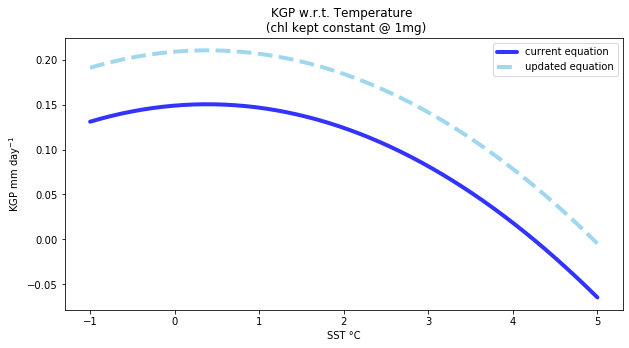

In [10]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set_title('KGP w.r.t. Temperature \n (chl kept constant @ 1mg)')

ax.plot(kgp_sst.SST, kgp_sst.KGP, color = 'blue',
         alpha = .8, linewidth = 4,
         solid_capstyle='round', label = 'current equation')

ax.plot(kgp_sst_test.SST, kgp_sst_test.KGP, color = 'skyblue',
         alpha = .8, linewidth = 4, linestyle = 'dashed',
         solid_capstyle='round', label = 'updated equation')

plt.xlabel("SST °C")
plt.ylabel("KGP mm day$^{-1}$")
plt.legend()
plt.gca()

#plt.savefig('figures/KGP with respect to chl.png')

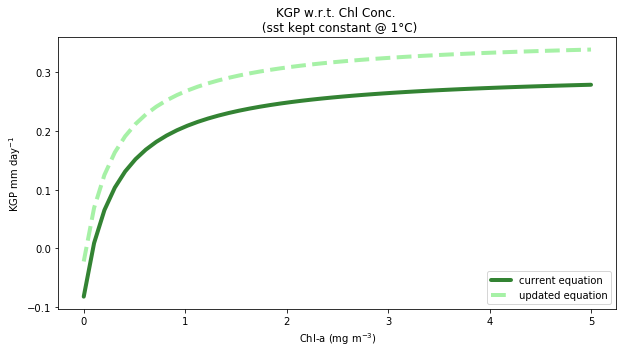

In [11]:
fig = plt.figure(figsize=(10,5))

ax2 = fig.add_subplot(111)
ax2.set_title('KGP w.r.t. Chl Conc. \n (sst kept constant @ 1°C)')
ax2.plot(kgp_chl.Chl_surf, kgp_chl.KGP, color = 'darkgreen',
         alpha = .8, linewidth = 4, 
         solid_capstyle='round', label = 'current equation')

ax2.plot(kgp_chl_test.Chl_surf, kgp_chl_test.KGP, color = 'lightgreen',
         alpha = .8, linewidth = 4, linestyle = 'dashed',
         solid_capstyle='round', label = 'updated equation')

#plt.xlabel("SST °C")
plt.xlabel("Chl-a (mg m$^{-3}$)")
plt.ylabel("KGP mm day$^{-1}$")
plt.legend(loc = 'lower right')
plt.gca()

#plt.savefig('figures/KGP with respect to chl.png')